In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings('ignore')
shap.initjs()


In [19]:
df = pd.read_csv('df.csv')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'])
df


,date,copper_price,buy_price,global_consumer_price_index,six_month_demand,gold_price,inventory
0,2020-01-01,3.137096,2.661115,117.999071,30.943593,2345.428509,11.721919
1,2020-02-01,3.080626,2.601521,121.141858,39.010606,2339.954887,34.574074
2,2020-03-01,3.116939,2.596875,122.787487,37.089984,1915.409552,28.794901
3,2020-04-01,3.180225,2.717195,124.483782,39.637642,2119.374158,40.498696
4,2020-05-01,3.220652,2.707316,121.855462,31.061250,2113.274844,34.927412
...,...,...,...,...,...,...,...
95,2027-12-01,3.510925,3.032640,196.290341,47.405890,2348.688526,22.279791
96,2028-01-01,3.397751,2.905826,197.409496,49.262588,2034.178653,6.486046
97,2028-02-01,3.251829,2.763559,199.246402,52.169598,1842.176256,46.331669
98,2028-03-01,3.259828,2.796132,199.289260,51.048567,2224.503966,39.992547


In [20]:
df_without_date = df.drop('date', axis=1)
df_without_date

,copper_price,buy_price,global_consumer_price_index,six_month_demand,gold_price,inventory
0,3.137096,2.661115,117.999071,30.943593,2345.428509,11.721919
1,3.080626,2.601521,121.141858,39.010606,2339.954887,34.574074
2,3.116939,2.596875,122.787487,37.089984,1915.409552,28.794901
3,3.180225,2.717195,124.483782,39.637642,2119.374158,40.498696
4,3.220652,2.707316,121.855462,31.061250,2113.274844,34.927412
...,...,...,...,...,...,...
95,3.510925,3.032640,196.290341,47.405890,2348.688526,22.279791
96,3.397751,2.905826,197.409496,49.262588,2034.178653,6.486046
97,3.251829,2.763559,199.246402,52.169598,1842.176256,46.331669
98,3.259828,2.796132,199.289260,51.048567,2224.503966,39.992547


In [21]:
import plotly.express as px

fig = px.line(df, x='date', y=df.columns[1:], title="Values Over Time")

fig.show()

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data into features (X) and target (y)
X = df_without_date.drop('six_month_demand', axis=1)
y = df_without_date['six_month_demand']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features if necessary
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (80, 5)
X_test shape: (20, 5)


In [23]:
from sklearn.model_selection import cross_val_score, KFold

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [24]:
from sklearn.ensemble import GradientBoostingRegressor

# Define Gradient Boosting Classifier with hyperparameters
gbr=GradientBoostingRegressor(n_estimators=600,learning_rate=0.005,random_state=42,max_features=5, criterion='squared_error', loss='squared_error', subsample=0.4)
# Fit train data to GBC
gbr.fit(X_train, y_train)

GradientBoostingRegressor(criterion='squared_error', learning_rate=0.005,
                          max_features=5, n_estimators=600, random_state=42,
                          subsample=0.4)

In [25]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = gbr.predict(X_test)

acc = gbr.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Wyświetlenie wyników
print(f'Mean Squared Error value: {mse:.2f}')
print(f'R-squared value: {r2:.2f}')
print(f"Accuracy: {acc: .2f}")

Mean Squared Error value: 14.32
R-squared value: 0.77
Accuracy:  0.77


In [26]:
importances = gbr.feature_importances_
print(importances)

[0.10492427 0.09539888 0.34376545 0.19149915 0.26441225]


In [27]:
cross_val_results = cross_val_score(gbr, X_test, y_pred, cv=kf)
print(f'Cross-Validation Results (Accuracy): {cross_val_results}')
print(f'Mean Accuracy: {cross_val_results.mean()}')

Cross-Validation Results (Accuracy): [0.73256407 0.04654772 0.68665623 0.7904371  0.8950383 ]
Mean Accuracy: 0.6302486854927033


In [28]:
explainer = shap.Explainer(gbr)
shap_values = explainer.shap_values(X_test)

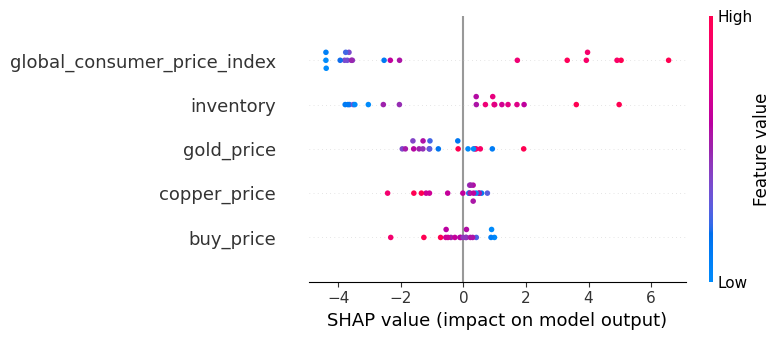

In [29]:
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

In [30]:
# import xgboost as xg 

# xgb_r = xg.XGBRegressor(objective ='reg:linear', 
#                   learning_rate = 0.05,
#                   booster='gblinear',
#                   sampling_method='gradient_based',
#                   n_estimators = 500, seed = 42) 
  
# # Fitting the model 
# xgb_r.fit(X_train, y_train) 
   
  

In [31]:

# # Predict the model 
# pred = xgb_r.predict(X_test)

In [32]:
# acc = gbr.score(X_test, y_test)
# mse = mean_squared_error(y_test, pred)
# r2 = r2_score(y_test, pred)

# # Wyświetlenie wyników
# print(f'Mean Squared Error value: {mse:.2f}')
# print(f'R-squared value: {r2:.2f}')
# print(f"Accuracy: {acc: .2f}")

In [44]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_components(result):

  df = pd.concat([result.observed, result.trend, result.seasonal, result.resid], axis=1)
  df = df.rename(columns={0:'Original Data', 'season':'seasonal','observed':'Original Data'})
  components = df.columns
  rows = len(components)
  fig = make_subplots(rows=rows, cols=1, shared_xaxes=True, subplot_titles = [i for i in components])
  
# Plot original data
  for i, col in enumerate(components):
    fig.add_trace(go.Scatter(x=df.index, y=df[col], mode='lines', name=col), row=i+1, col=1)


  # Update layout
  fig.update_layout(
      title='Time Series Decomposition',
      xaxis_title='Time',
      height=1200,
      width=1200
  )

  fig.show()

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL

decomposition = seasonal_decompose(df['six_month_demand'], model='multiplicative', period=12)
plot_components(decomposition)

In [52]:
stl = STL(df['six_month_demand'], period=12)
result_stl = stl.fit()

# Plot the results
plot_components(result_stl)

In [55]:
mstl = MSTL(df['six_month_demand'], periods=[12, 100])
result_mstl = mstl.fit()

# Plot the results
plot_components(result_mstl)